# Rad Lab

Builds spectra for common sources of ionizing radiation

© 2025 by Gissio

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import paceENSDF as pe
import spekpy as sp

e = pe.ENSDF()
edata = e.load_ensdf()

# %matplotlib widget

Loading ENSDF data sets, please wait...
3254 JSON-formatted ENSDF-decay data sets loaded.


## Functions

### General spectrum functions

In [2]:
def print_spectrum(spectrum):
    if not spectrum:
        print("No spectral lines found.")
        return

    print(f"{'Energy (keV)':>12s}   {'Intensity':>14s}")
    print("-" * 30)

    for energy in spectrum:
        intensity = spectrum[energy]
        print(f"{energy:12.3f}   {intensity:14.8f}")


def combine_spectra(spectra):
    combined_spectrum = {}

    for spectrum in spectra:
        for energy in spectrum:
            intensity = spectrum[energy]
            if energy not in combined_spectrum:
                combined_spectrum[energy] = 0
            combined_spectrum[energy] += intensity

    return combined_spectrum

### Nuclide decay spectra

* See ENSDF manual: https://www.nndc.bnl.gov/ensdf/ensdf-manual.pdf

In [3]:
def get_decay_spectrum_recursive(edata, nuclide, weight, spectrum, depth, depth_max):
    if depth >= depth_max:
        return

    nuclide_decay_index = 0
    if nuclide.endswith("m"):
        nuclide = nuclide[:-1]
        nuclide_decay_index = 1

    for record in edata:
        # Parse parent id
        parent_id = record["parentID"]

        # Matching nuclide
        if parent_id != nuclide:
            continue

        # Matching decay state
        is_ground_state = record["decayIndex"] == nuclide_decay_index
        if not is_ground_state:
            continue

        # Normalization
        normalization_record = record["decaySchemeNormalization"][0]["normalizationRecord"][0]
        multipler_photon_intensity = normalization_record["multiplerPhotonIntensity"]
        multipler_branching_ratio = normalization_record["multiplerBranchingRatio"]

        # Daughter nuclide
        daughter_id = record["daughterID"]
        daughter_weight = weight * multipler_branching_ratio

        # Half-life in years
        half_life_years = record["parentDecay"][0]["halfLife"][0]["halfLifeConverted"] / 31556926

        # Spectral lines
        for level_scheme in record["levelScheme"]:
            for gamma_decay in level_scheme["gammaDecay"]:
                energy = gamma_decay["gammaEnergy"]
                intensity = gamma_decay["gammaIntensity"] / 100

                normalized_intensity = intensity * multipler_photon_intensity * \
                    multipler_branching_ratio * weight

                if energy not in spectrum:
                    spectrum[energy] = 0
                spectrum[energy] += normalized_intensity

        # Debug helper
        # print(f'{parent_id} > {daughter_id}: {half_life_years}, {daughter_weight}')

        # Follow decay chain
        get_decay_spectrum_recursive(
            edata, daughter_id, daughter_weight, spectrum, depth + 1, depth_max)

    return spectrum


def get_decay_spectrum(edata, nuclide, weight=1, depth_max=100):
    spectrum = {}

    get_decay_spectrum_recursive(
        edata, nuclide, weight, spectrum, 0, depth_max)

    return spectrum


def get_half_life(edata, nuclide):
    for record in edata:
        # Matching nuclide
        parent_id = record["parentID"]
        if parent_id != nuclide:
            continue

        # Half-life in years
        half_life_years = record["parentDecay"][0]["halfLife"][0]["halfLifeConverted"] / 31556926
        return half_life_years

    return None


def get_atomic_mass(edata, nuclide):
    for record in edata:
        # Matching nuclide
        parent_id = record["parentID"]
        if parent_id != nuclide:
            continue

        # Atomic mass
        atomic_mass = record["parentAtomicMass"]
        return atomic_mass

    return None


def get_decay_weights(edata, nuclides_normalized_masses):
    decay_weights = {}
    decay_weight_sum = 0

    for nuclide, normalized_mass in nuclides_normalized_masses.items():
        atomic_mass = get_atomic_mass(edata, nuclide)
        half_life = get_half_life(edata, nuclide)
        nuclide_lambda = np.log(2) / half_life

        decay_weight = normalized_mass * nuclide_lambda / atomic_mass
        decay_weight_sum += decay_weight

        decay_weights[nuclide] = decay_weight

    for nuclide in decay_weights:
        decay_weights[nuclide] /= decay_weight_sum

    return decay_weights

### X-ray tube spectra

In [4]:
def get_xray_spectrum(voltage_kv, tube_angle, al_filter_width):
    r = sp.Spek(kvp=voltage_kv, th=tube_angle)
    r.filter('Al', al_filter_width)
    energies, intensities = r.get_spectrum()

    # Normalize
    intensities /= np.max(intensities)

    return {k: v for k, v in zip(energies, intensities)}

### Natural background spectrum

In [5]:
def get_natural_background_spectrum():
    energies = np.arange(10, 3600, 1).astype(float)

    # Typical gamma ray spectrum: https://www.researchgate.net/figure/A-typical-gamma-ray-spectrum-of-the-ambient-background-in-the-TiLES-where-the-prominent_fig1_358898914
    # Modeled as: 
    
    alpha = 1.5
    max = 100
    intensities = np.pow(energies / max, -alpha) * np.exp(alpha * (1 - max / energies))

    return {k: v for k, v in zip(energies, intensities)}

## Build spectra

In [8]:
natural_uranium_weights = get_decay_weights(edata, {
    "U235": 0.00711,
    "U238": 0.99289,
})

depleted_uranium_weights = get_decay_weights(edata, {
    "U235": 0.002,
    "U238": 0.998,
})

spectra = {}
spectra["Cs-137"] = get_decay_spectrum(edata, "Cs137")
spectra["Co-60"] = get_decay_spectrum(edata, "Co60")
spectra["Tc-99m"] = get_decay_spectrum(edata, "Tc99m")
spectra["I-131"] = get_decay_spectrum(edata, "I131")
spectra["Lu-177"] = get_decay_spectrum(edata, "Lu177")
spectra["Am-241"] = get_decay_spectrum(edata, "Am241", depth_max=1)
spectra["Radium"] = get_decay_spectrum(edata, "Ra226")
spectra["Uranium ore"] = combine_spectra([
    get_decay_spectrum(edata, "U235", natural_uranium_weights["U235"]),
    get_decay_spectrum(edata, "U238", natural_uranium_weights["U238"]),
])
spectra["Uranium glaze"] = combine_spectra([
    get_decay_spectrum(edata, "U235", natural_uranium_weights["U235"], depth_max=2),
    get_decay_spectrum(edata, "U238", natural_uranium_weights["U238"], depth_max=3),
])
spectra["Depleted uranium"] =  combine_spectra([
    get_decay_spectrum(edata, "U235", depleted_uranium_weights["U235"], depth_max=2),
    get_decay_spectrum(edata, "U238", depleted_uranium_weights["U238"], depth_max=3),
])
spectra["Thorium ore"] = get_decay_spectrum(edata, "Th232")
spectra["X-ray tube (60 kV)"] = get_xray_spectrum(60, 12, 4)
spectra["K-40"] = get_decay_spectrum(edata, "K40")
spectra["Natural background"] = get_natural_background_spectrum()

# Dump spectra to json
with open("data/spectra.json", "w") as f:
    json.dump(spectra, f, indent=2)

## Plots

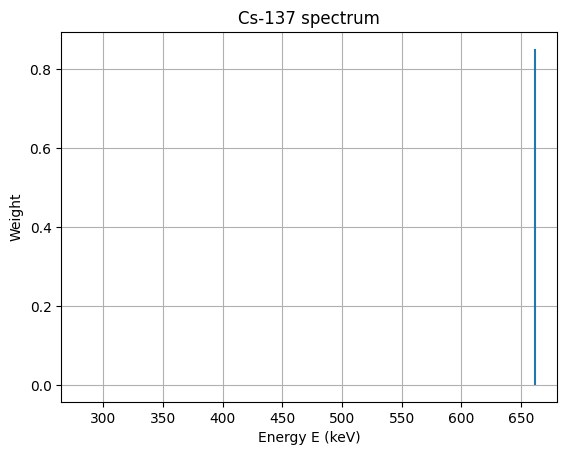

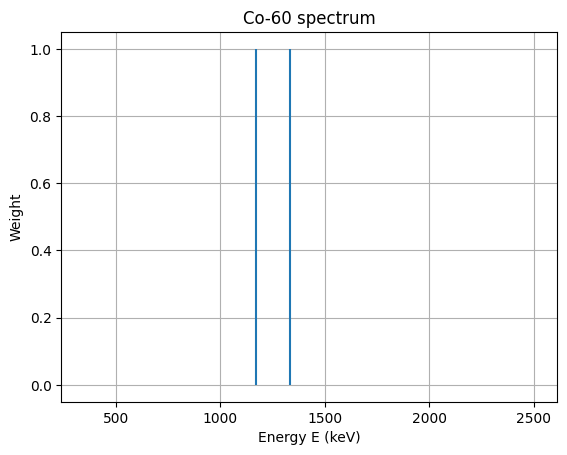

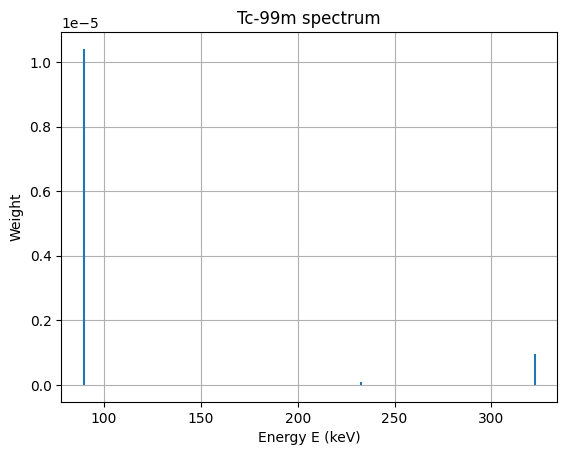

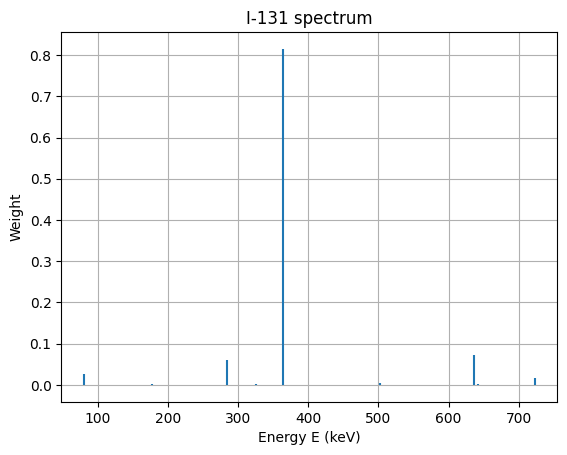

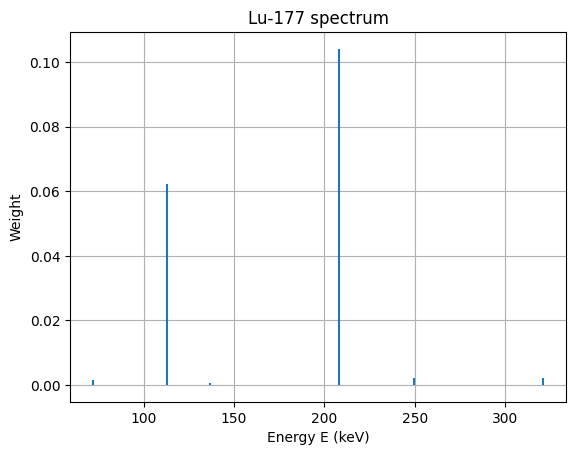

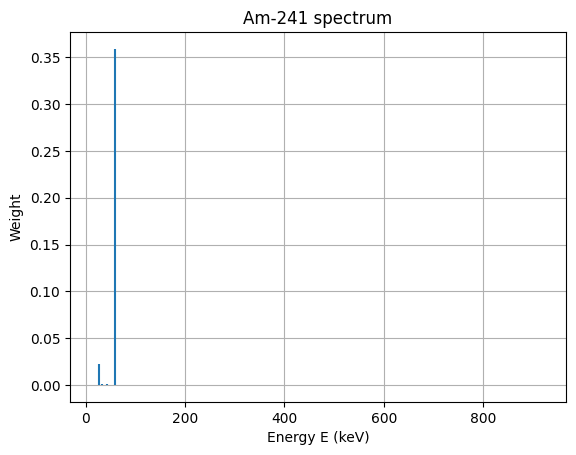

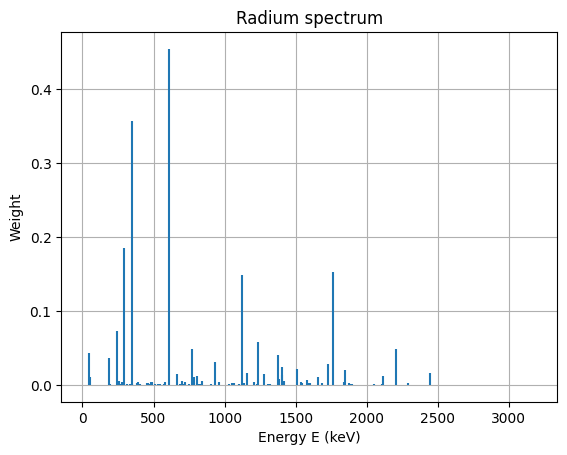

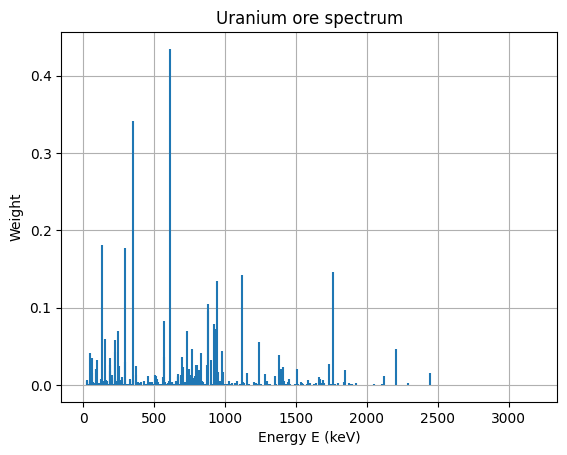

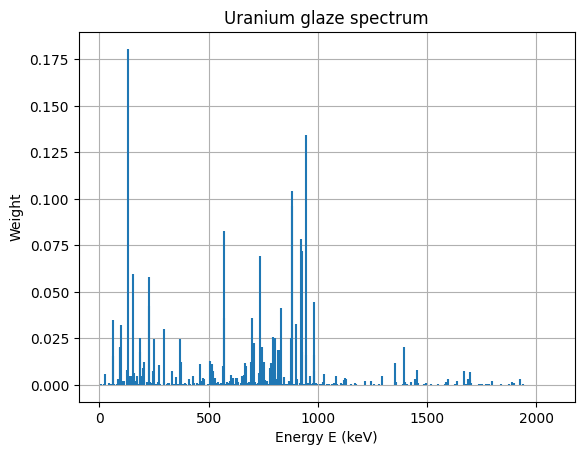

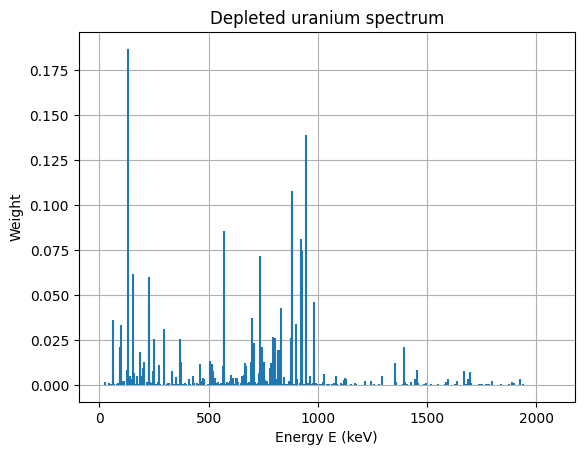

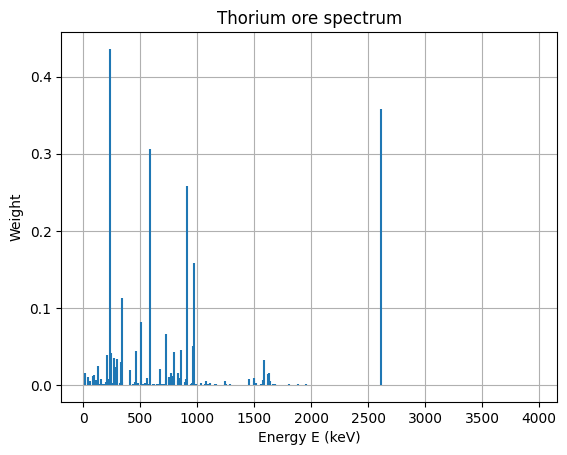

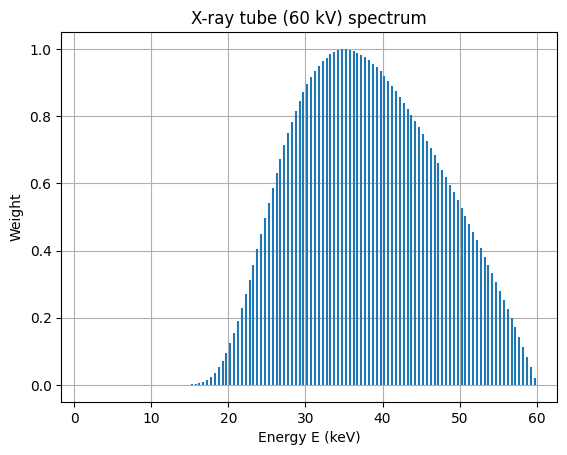

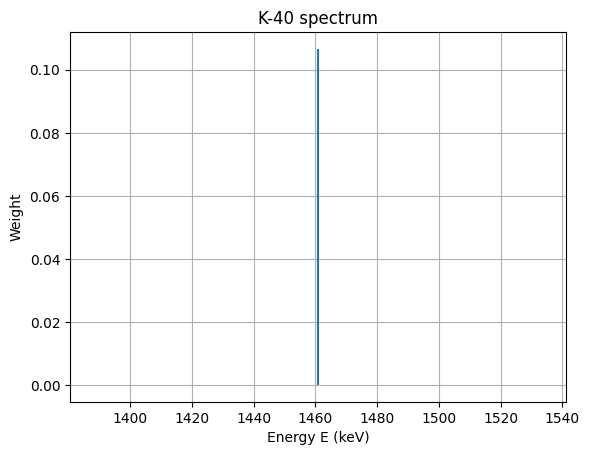

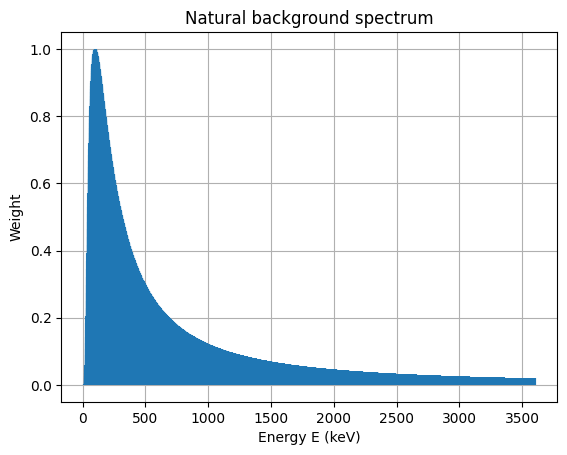

In [7]:
N_energies = 32
energies = np.logspace(np.log10(0.01), np.log10(3.6), N_energies).tolist()

for nuclide, spectrum in spectra.items():
    spectrum_energy = spectrum.keys()
    spectrum_weight = spectrum.values()

    plt.figure()
    plt.stem(spectrum_energy, spectrum_weight, basefmt=' ', markerfmt=' ')
    plt.xlabel("Energy E (keV)")
    plt.ylabel("Weight")
    plt.title(f"{nuclide} spectrum")
    plt.grid(True)
    plt.show()